# O-D Estimation by stratum

The objective of this notebook is to create O-D matrices by stratum, and the total O-D matrix. The goal is to select the origins-destination pairs with greater participation of strata 1 and 2, and the others O-Ds witht the greatest reduction of transactions in general (as a way to to from where to take the resources). 

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import pyspark as ps
sc = ps.SparkContext(appName="odmatrix")

from pyspark.sql import * #This enables the SparkSession object
spark = SparkSession.builder\
        .master("local") \
        .appName("odmatrix") \
        .getOrCreate()

In [2]:
from os import path
import time 
import random 
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import glob
warnings.filterwarnings('ignore')

from pyspark.sql.functions import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.functions import pow, col, sqrt

## Input data 

In [3]:
output_path = '../data/output/'
input_path = '../data/input/'

transactions = spark.read.csv(output_path + 'tables/transactions_frequent_users.csv', header =True, sep = ',')
hw_location = spark.read.csv(output_path + 'tables/hw_location.csv', header =True, sep = ',')
probs = pd.read_csv(output_path + 'tables/stratum_probabilities.csv', parse_dates = ['date'],
                    infer_datetime_format= True).drop(columns = 'total')

## Data preprocessing

In [4]:
def add_date(df, col_date = 'date', format_date = 'd/M/yy'):
    """ Note: This is no longer needed. The format date in stratum is not consistent with pySpark. 
        Solution: Read probabilities as a dataframe and parse date (which gave good resutls) and then 
        transform pandas dataframe to pyspark"""
    return df.withColumn(col_date,to_date(unix_timestamp(col(col_date),format_date).cast("timestamp")))

# stratum_probabilities = add_date(stratum_probabilities, col_date = 'date', format_date = 'd/M/yy')
probs = spark.createDataFrame(probs)

In [5]:
# s_path = '/Users/juandavidcaicedocastro/Dropbox/01_berkeley/17_phd/08_results/helper_tables/'
# stations = spark.read.csv(s_path  + 'cleaned_stations.csv', header =True, sep = ',')

#### Goals 
- Create H-W matrix and calculate aggregate travel time, with standard deviation 
- Create W-H matrix and calculate aggregate travel time, with standard deviation 

## Estimating matrices by the week instead 

### Data structure
The week matrix is a data abstractions objectect that contains 28 matrixes per week. 
The hierarcy of the elemenet is as follows: 

week_matrix: A list of 2 elemenets. 
             Element 0 has the HOME-WORK matrix, and element 0 has the WORK-HOME matrix
             
HOME-WORK/WORK-HOME matrix: A list of 7 elements 

In [6]:
def time_format(df, date_col = 'fechatransaccion', time_col = "horatransaccion"):
    ''' Returns dataframe with date and time as a timestamp format
    Input: 
     - df: PySpark dataframe: Raw transactions
     - date_col: str. Column name for date 
     - time_col: str. Column name for time
     
     Return: 
     PySpark dataframe. 
     Time col:
     - timestamp: time in 'to_timestamp' format '''
    # add time
    df = df.withColumn("timestamp",
        to_timestamp(col(time_col),"HH:mm:ss"))\
        .withColumn("hour", hour(col("timestamp")))\
        .withColumn("minute", minute(col("timestamp")))\
        .withColumn("second", second(col("timestamp")))\
        .withColumn('time', col('hour') + col('minute')/60 + col('second')/3600)
    
    # add date
    df = df.withColumn('date', to_date(unix_timestamp(col(date_col), 'yyyyMMdd').cast("timestamp")))
    return df

In [7]:
def merge_probabilities(df, probs):
    """Join probaibility vectors to transactions data. 
    Note transactions data should already have H-W location joined """
    
    cond = [df.home_station == probs.station_name, df.date == probs.date]
    result = df.join(probs, cond, 'left').drop(probs.date).drop(probs.station_name)
    return result

In [8]:
def preprocessing_transactions(transactions, hw_location, probs):
    """ Preprocess raw transactions data. The preprocessing includes
         - transform date and time to datime format
         - map shorter version of card ID 
         - add home and work location for each user 
         - merge stratum probabilities 
        """
    df = transactions.transform(lambda df: time_format(df))\
        .join(hw_location, on = 'card_id', how = 'inner')\
        .transform(lambda df: merge_probabilities(df, probs)) 
    
    df = df#.drop('_c0')
    return df

In [9]:
def filter_dates(df, start , end):
    return df.filter(col('date').between(start, end))

In [10]:
def matrix_grouping(df, origin, destination):
    """ Aggregates transactions by origin and destination 
        Input: 
        - df: PySpark dataframe. Transactions 
        - origin: str. Column name with origin station. ['home_station', 'work_station']
        - destination: str. column name with destination station"""
    
    if origin == "home_station":
        col_name = "home_transactions"
    else:
        col_name = "work_transactions"
    
    
    grouping_dict = {'fechatransaccion':'count', 'time':'mean',
                     'stratum1':'mean', 'stratum2':'mean', 'stratum3':'mean',
                     'stratum4':'mean', 'stratum5':'mean', 'stratum6':'mean'}
    
    
    od_df = df.withColumn(col_name, col("station_name") == col(origin))\
              .filter(col(col_name) == True)\
              .groupBy([origin, destination, 'date'])\
              .agg(grouping_dict)
    return od_df

In [11]:
def day_of_week(week_matrix):
    ''' Returns the day of the week. A number from 0 to 6
        0 = Monday
        1 = Tuesday
        2 = Wednesday
        3 = Thrusday
        4 = Friday 
        5 = Saturday 
        6 = Sunday
        week_matrix: This is a week_matrix format with a column that is called date'''
    
    for matrix in week_matrix:
        matrix['date'] = pd.to_datetime(matrix.date)
        matrix['day_of_week'] = matrix['date'].dt.dayofweek
    return week_matrix

In [12]:
def OD_aggregation_week(data, date_start, date_end):
    ''' Creates HW and WH matrices for each day of the week, and store them in a list of list
        This is the data week_matrix constructure
        Input: 
        - data: pySpark DataFrane. Preprocessed data, as in preprocessing_transactions function 
        - start_date: 
        - end_date: 
        Output: OD elment with ['HOME_WORK', "WORK_HOME"]'''
    
    data = filter_dates(data, start = date_start, end = date_end)
    
    hw_data = matrix_grouping(data, "home_station", "work_station")
    hw_data = hw_data.toPandas()
    hw_data.rename(columns = {"home_station": "origin","work_station":"destination",
                              'count(fechatransaccion)':'transacction', 'avg(time)':'avg_travel_time',
                              'avg(stratum1)': "strata1", 'avg(stratum4)': "strata4",
                              'avg(stratum2)': "strata2", 'avg(stratum6)': "strata6",
                              'avg(stratum3)': "strata3", 'avg(stratum5)': "strata5"}, inplace = True)
    
    wh_data = matrix_grouping(data, "work_station", "home_station")
    wh_data = wh_data.toPandas()
    wh_data.rename(columns = {"work_station":"origin", "home_station":"destination",
                              'count(fechatransaccion)':'transacction', 'avg(time)':'avg_travel_time',
                              'avg(stratum1)': "strata1", 'avg(stratum4)': "strata4",
                              'avg(stratum2)': "strata2", 'avg(stratum6)': "strata6",
                              'avg(stratum3)': "strata3", 'avg(stratum5)': "strata5"}, inplace = True)
    
    week_matrix = [hw_data, wh_data] 
    week_matrix = day_of_week(week_matrix)
    return week_matrix

In [13]:
def build_day_matrices(week_matrix_element):
    """ Separates an element of OD matrix by the day of the week 
        Input:
        - week_matrix_element: pandas DataFrame. 
    """
    day_matrix_list = []
    for day in range(7): #7 days of the week (0-6)
        day_matrix = week_matrix_element[week_matrix_element.day_of_week == day]
        day_matrix_list.append(day_matrix)
    return day_matrix_list

In [14]:
def OD_aggregation_day(week_matrix):
    """ Creates an OD matrix aggregated by the day
        Input: 
        - week_matrix: Week_matrix object """
    od_day = []
    for matrix in week_matrix: 
        od_day.append(build_day_matrices(matrix))
        
    return od_day

In [15]:
def build_stratum_matrix(day_data, strata = ['strata1','strata2','strata3','strata4','strata5','strata6']):
    ''' Returns one OD matrix that represents the stratum in strata
        Eg. if strata = ['strata1','strata2'], it will generate a OD of strata 1 + strata 2'''
    
    day_data['pct'] = day_data[strata].sum(axis = 1)
    day_data['stratum_transactions'] = day_data['transacction'] * day_data['pct']
    
#     matrices_list = []
#     for stratum in stratum_transactions: 
#         od_matrix = pd.pivot_table(df, 
#                            values= stratum,
#                            index=[origin],
#                            columns=[destination], 
#                            aggfunc=np.sum)
        
#         matrices_list.append(od_matrix)
    return day_data[['origin', 'destination', 'stratum_transactions']]

In [16]:
def od_agg_stratum_(day_matrix, groups = [['strata1'], ['strata2'],
                                          ['strata3'], ['strata4'],
                                          ['strata5'], ['strata6']]):
    stratum_matrix = []
    for day in day_matrix:
        g1 = build_stratum_matrix(day, strata = groups[0])
        g2 = build_stratum_matrix(day, strata = groups[1])
        g3 = build_stratum_matrix(day, strata = groups[2])
        g4 = build_stratum_matrix(day, strata = groups[3])
        g5 = build_stratum_matrix(day, strata = groups[4])
        g6 = build_stratum_matrix(day, strata = groups[5])
        stratum_matrix.append([g1, g2, g3, g4, g5, g6])
    return stratum_matrix


# def od_agg_stratum_(day_matrix, groups = [['strata1', 'strata2'], 
#                                          ['strata3', 'strata4','strata5', 'strata6']]):
#     stratum_matrix = []
#     for day in day_matrix:
#         g1 = build_stratum_matrix(day, strata = groups[0])
#         g2 = build_stratum_matrix(day, strata = groups[1])
#         stratum_matrix.append([g1, g2])
#     return stratum_matrix

In [17]:
def od_agg_stratum(day_data, strata_group = [['strata1'], ['strata2'],
                                             ['strata3'], ['strata4'],
                                             ['strata5'], ['strata6']]):
    
    week_matrix_element = []
    for day in day_data:
        element = od_agg_stratum_(day, groups = strata_group )
            
        week_matrix_element.append(element)
    return week_matrix_element

In [69]:
%%time
df = preprocessing_transactions(transactions, hw_location, probs)
week_matrix = OD_aggregation_week(df, date_start = '2020-04-06' ,  date_end = '2020-04-12')
day_matrix = OD_aggregation_day(week_matrix)
stratum_matrix = od_agg_stratum(day_matrix)

CPU times: user 1.42 s, sys: 304 ms, total: 1.73 s
Wall time: 5min 25s


In [76]:
stratum_matrix[0][0][5].head()

,origin,destination,stratum_transactions
13,(09122) Calle 72,(03000) Portal Suba,7.074694
15,(07007) NQS - Calle 38A Sur,(02102) Calle 161,0.000000
35,(03011) SUBA - CALLE 100,(03002) SUBA - TV- 91,0.000000
39,(40001) Juan Pablo II,(09113) Calle 22,0.000000
49,(07000) Portal Sur - alimentacion,(05001) Patio Bonito,0.000000


## Getting matrix element before and after the pandemic 

Selected weeks:
- February 17, 2020 - February 23, 2020 (PRE-COVID)
- October 5, 2020 - October 11, 2020

In [18]:
%%time
df = preprocessing_transactions(transactions, hw_location, probs)
bs_week_matrix = OD_aggregation_week(df, date_start = '2020-02-17' ,  date_end = '2020-02-23')
bs_day_matrix = OD_aggregation_day(bs_week_matrix)
bs_stratum_matrix = od_agg_stratum(bs_day_matrix)

CPU times: user 2.45 s, sys: 255 ms, total: 2.7 s
Wall time: 6min 55s


In [19]:
%%time
post_week_matrix = OD_aggregation_week(df, date_start = '2020-10-05' ,  date_end = '2020-10-11')
post_day_matrix = OD_aggregation_day(post_week_matrix)
post_stratum_matrix = od_agg_stratum(post_day_matrix)

CPU times: user 1.79 s, sys: 142 ms, total: 1.93 s
Wall time: 5min 26s


In [86]:
bs_stratum_matrix[0][0][4]

,origin,destination,stratum_transactions
2,(04001) Quirigua,(05100) Banderas P. Central - alimentacion,0.000000
10,(10003) Ciudad Jardín,(02201) Prado,0.000000
16,(06000) Portal Eldorado,(14001) La Sabana,0.000000
17,(06000) Portal Eldorado,(12007) Zona Industrial,0.000000
67,(02304) Heroes,(07008) NQS - Calle 30 Sur,12.409180
...,...,...,...
164349,(07101) CASTELLANA,(02502) Terminal,0.000000
164354,(07105) MOVISTAR ARENA,(40003) Mirador del Paraiso,0.280794
164355,(07010) Bosa,(03005) SUBA - AV. BOYACA,0.000000
164368,(04108) El Polo,(03001) LA CAMPIÑA,0.000000


## Analysis 

[H/W][Day][Stratum]

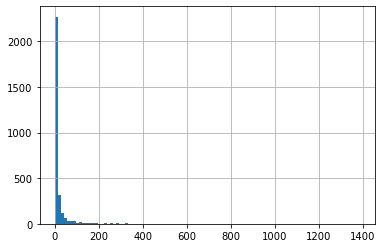

In [106]:
# Top ten (+ -) by stratum
a = bs_stratum_matrix[0][0][0].sort_values('stratum_transactions', ascending = False).round(0)#.head(50)
a = a[a.stratum_transactions > 0]
a['stratum_transactions'].hist(bins = 100)

In [158]:
a

,origin,destination,stratum_transactions
66624,(40003) Mirador del Paraiso,(08000) Portal Tunal,1383.0
63382,(08000) Portal Tunal - alimentacion,(09110) Avenida Jimenez,859.0
7378,(09000) Cabecera Usme - alimentacion,(09000) Cabecera Usme,790.0
136339,(08000) Portal Tunal - alimentacion,(09118) Marly,788.0
83817,(08000) Portal Tunal - alimentacion,(09120) Calle 63,759.0
...,...,...,...
72262,(09118) Marly,(03003) 21 ANGELES,1.0
36879,(09118) Marly,(04107) Escuela Militar,1.0
103490,(09118) Marly,(14001) La Sabana,1.0
138765,(09118) Marly,(10006) San Victorino,1.0


In [111]:
hw_s1 = a.stratum_transactions.sum()
hw_s1 

62597.0

In [157]:
hw_s1 *.8

50077.600000000006

In [120]:
remain_s1 = a[a.stratum_transactions > 20].stratum_transactions.sum()
remain_s1/hw_s1 

0.8009489272648849

In [148]:
top = a.head(542).stratum_transactions.sum()
top/hw_s1

0.800277968592744

In [150]:
top80pct = a.head(542)

In [155]:
len(top80pct.origin.unique())

19

In [156]:
top80pct

,origin,destination,stratum_transactions
66624,(40003) Mirador del Paraiso,(08000) Portal Tunal,1383.0
63382,(08000) Portal Tunal - alimentacion,(09110) Avenida Jimenez,859.0
7378,(09000) Cabecera Usme - alimentacion,(09000) Cabecera Usme,790.0
136339,(08000) Portal Tunal - alimentacion,(09118) Marly,788.0
83817,(08000) Portal Tunal - alimentacion,(09120) Calle 63,759.0
...,...,...,...
13905,(09000) Cabecera Usme - alimentacion,(10007) Las Nieves,21.0
132541,(40002) Manitas,(06000) Portal Eldorado - alimentacion,21.0
24006,(40002) Manitas,(09119) Calle 57,21.0
108459,(08000) Portal Tunal - alimentacion,(10000) Portal 20 de Julio,21.0


## Define operators for matrix object

In [ ]:
def pct_change(week_1, week_2):
    ''' Calculates percentual chage between week one and week two'''
    type_category = 2
    days = 7 
    strata = 2
    
    #Data validation 
    assert len(week_1) == type_category
    assert len(week_2) == type_category
    assert len(week_1[0]) == days
    assert len(week_2[0]) == days
    assert len(week_1[0][0]) == strata
    assert len(week_2[0][0]) == strata
    
    category_pct = []
    for category in type_category:
        day_pct = []
        for day in days:
            stratum_pct = []
            for stratum in strata: 
                
                a = a.set_index(['origin', 'destination'])
                b = b.set_index(['origin', 'destination'])
                c = (a - b)/a
                
                week_1_t = week_1[category][day][stratum]['stratum_trasaction']
                week_2_t = week_2[category][day][stratum]['stratum_trasaction']
                pct_ = (week_1_t - week_2_t)/week_1_t
                stratum_pct.append(pct_)
            day_pct.append(stratum_pct)
        category_pct.append(day_pct)
    
    return category_pct

In [ ]:
bs_stratum_matrix[0][0][0]

In [46]:
indeces_1 = [7485,  17779,  3599, 20221,   8901, 21019,
             7936,  7952, 14603, 20140, 15526,  6177, 20684,  2341,   740,
            16821, 14468]

indeces_2 = [9774, 15228, 16755, 14786, 13463,
            14966,  8185,   941,  9208, 13827, 15505,  8510, 10422, 11847,]

In [87]:
a = bs_stratum_matrix[1][0][0]
b = post_stratum_matrix[1][0][0]
c = a.merge(b, on = ['origin', 'destination'] , how = 'outer').fillna(0)
c['diff'] = c['stratum_transactions_y'] - c['stratum_transactions_x']
c['change'] = c['diff']/c['stratum_transactions_x']
# c.sort_values('stratum_transactions_x', ascending=False)
d = c[c.stratum_transactions_x.between(500,26000)].sort_values('change', ascending=True).loc[indeces_2].head(10)

In [88]:
d#.destination

,origin,destination,stratum_transactions_x,stratum_transactions_y,diff,change
9774,(03006) NIZA - CALLE 127,(03000) Portal Suba,586.642068,255.696000,-330.946068,-0.564136
15228,(02200) Alcalá,(09000) Cabecera Usme,527.000000,215.000000,-312.000000,-0.592030
16755,(02202) Calle 127,(07000) Portal Sur,543.877860,214.142875,-329.734986,-0.606267
14786,(12003) Ricaurte,(05000) Portal Américas,683.163231,250.144529,-433.018702,-0.633844
13463,(02202) Calle 127,(05000) Portal Américas,683.163231,241.712691,-441.450540,-0.646186
14966,(12002) CDS - Carrera 32,(05000) Portal Américas,620.182754,216.417177,-403.765577,-0.651043
8185,(09104) Restrepo,(09000) Cabecera Usme,796.000000,276.000000,-520.000000,-0.653266
941,(02200) Alcalá,(05000) Portal Américas,635.053144,220.164660,-414.888484,-0.653313
9208,(10006) San Victorino,(07000) Portal Sur,626.034637,215.957645,-410.076992,-0.655039
13827,(09110) Avenida Jimenez,(08000) Portal Tunal,623.278971,214.216327,-409.062644,-0.656307


In [15]:
# Strata 1-2
origin_000 = {7000:'origin',9000:1,10000:1,3000:1,5000:1}
destinations_000 = {7111:2,2200:2,2202:2,12004:2,7103:2,2101:2,12007:2}

origin_000 = {7000:'origin',9000:'origin',10000:'origin',3000:'origin',5000:'origin',
              7111:'destination',2200:'destination',2202:'destination',12004:'destination',
              7103:'destination',2101:'destination',12007:'destination'}

origin_100 = [3006,2200,2202,12003,2202,12002,9104,2200,10006,9110]
destinations_100 = [3000,9000,7000,5000,8000]

# Strata 3-4
origin_001 = [2200, 2104, 2000, 5100, 4000, 2101, 2200, 5100]
destinations_001 = [9117, 2300, 14005, 6111, 9122, 14004]

origin_101 = [14005, 6111, 9117, 9122, 9114, 14005, 9120]
destinations_101 = [5100, 4000,2000,6000]

In [52]:
#Plotting restuls the way I can for now 
import geopandas as gpd

s_path = '/Users/juandavidcaicedocastro/Dropbox/01_berkeley/17_phd/08_results/catchment_areas/'

stations = gpd.read_file(s_path  + 'catchment_areas.shp')

# Localidades shapefiles
lsoas_link = '/Users/juandavidcaicedocastro/Dropbox/01_berkeley/17_phd/07_notebooks/cp255/data/localidades_shp/Loca.shp'
lsoas = gpd.read_file(lsoas_link)
lsoas.drop(index = 8, inplace= True )

In [53]:
origin_000 = [7000,9000,10000,3000,5000]
destinations_000 = [7111,2200,2202,12004,7103,2101,12007]


origin_100 = [3006,2200,2202,12003,2202,12002,9104,2200,10006,9110]
destinations_100 = [3000,9000,7000,5000,8000]

# Strata 3-4
origin_001 = [2200, 2104, 2000, 5100, 4000, 2101, 2200, 5100]
destinations_001 = [9117, 2300, 14005, 6111, 9122, 14004]

origin_101 = [14005, 6111, 9117, 9122, 9114, 14005, 9120]
destinations_101 = [5100, 4000,2000,6000]

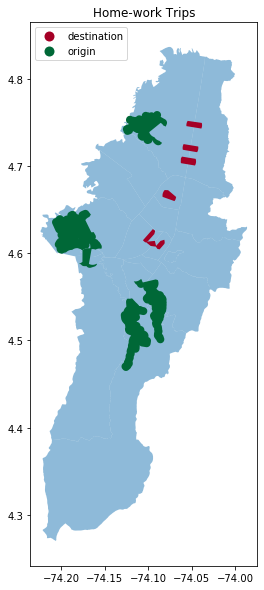

In [77]:
#Filtering
stations['a'] = stations.recaudoest.isin(origin_000)*1
stations['b'] = stations.recaudoest.isin(destinations_000)*2
stations['ab'] = stations['a'] + stations['b']
stations['ab'] = stations['ab'].replace({1:'origin', 2:'destination'})

fig, ax = plt.subplots(figsize = (10,10))
lsoas.plot(alpha=0.5, linewidth=1, ax=ax)
stations[stations['ab'].isin(['origin','destination'])].plot(column = 'ab',ax=ax, legend = True,
                                                            legend_kwds={'loc': 'upper left'},
                                                            cmap = 'RdYlGn');

ax.set_title('Home-work Trips');

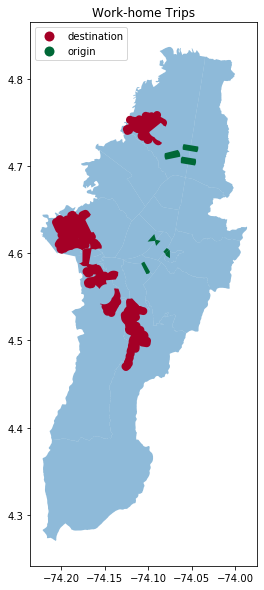

In [76]:
#Filtering
stations['a'] = stations.recaudoest.isin(origin_100)*1
stations['b'] = stations.recaudoest.isin(destinations_100)*2
stations['ab'] = stations['a'] + stations['b']
stations['ab'] = stations['ab'].replace({1:'origin', 2:'destination'})

fig, ax = plt.subplots(figsize = (10,10))
lsoas.plot(alpha=0.5, linewidth=1, ax=ax)
stations[stations['ab'].isin(['origin','destination'])].plot(column = 'ab',ax=ax, legend = True,
                                                            legend_kwds={'loc': 'upper left'},
                                                            cmap = 'RdYlGn');
ax.set_title('Work-home Trips');

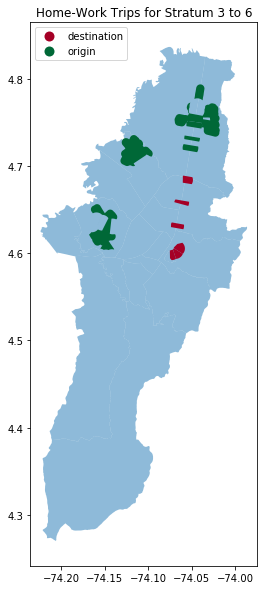

In [79]:
#Filtering
stations['a'] = stations.recaudoest.isin(origin_001)*1
stations['b'] = stations.recaudoest.isin(destinations_001)*2
stations['ab'] = stations['a'] + stations['b']
stations['ab'] = stations['ab'].replace({1:'origin', 2:'destination'})

fig, ax = plt.subplots(figsize = (10,10))
lsoas.plot(alpha=0.5, linewidth=1, ax=ax)
stations[stations['ab'].isin(['origin','destination'])].plot(column = 'ab',ax=ax, legend = True,
                                                            legend_kwds={'loc': 'upper left'},
                                                            cmap = 'RdYlGn');
ax.set_title('Home-Work Trips for Stratum 3 to 6');

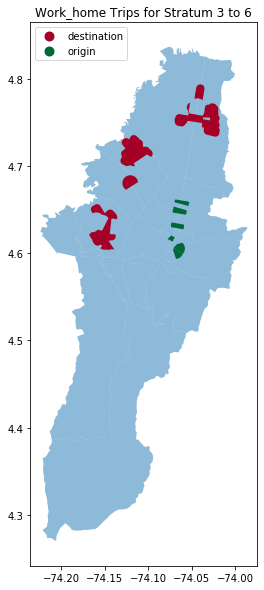

In [80]:
#Filtering
stations['a'] = stations.recaudoest.isin(origin_101)*1
stations['b'] = stations.recaudoest.isin(destinations_101)*2
stations['ab'] = stations['a'] + stations['b']
stations['ab'] = stations['ab'].replace({1:'origin', 2:'destination'})

fig, ax = plt.subplots(figsize = (10,10))
lsoas.plot(alpha=0.5, linewidth=1, ax=ax)
stations[stations['ab'].isin(['origin','destination'])].plot(column = 'ab',ax=ax, legend = True,
                                                            legend_kwds={'loc': 'upper left'},
                                                            cmap = 'RdYlGn');
ax.set_title('Work_home Trips for Stratum 3 to 6');